In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-dataset/weatherHistory.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.ar_model import AutoReg

In [3]:
# df = pd.read_csv("/kaggle/input/weather-dataset/weatherHistory.csv")
# df.head()

**Consider the rain as the target 1st**

In [4]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    df.drop(columns = ["Formatted Date","Loud Cover", "Apparent Temperature (C)", "Summary", "Daily Summary"], inplace=True)
    mask_humidity = df["Humidity"] > 0.1
    mask_windspeed = df["Wind Speed (km/h)"] < 59
    mask_pressure = df["Pressure (millibars)"] > 800
    
    df = df[mask_humidity & mask_windspeed & mask_pressure]
    
    df["Precip Type"] = (df["Precip Type"] == "rain").astype(int)
    
    return df

In [5]:
df = wrangle("/kaggle/input/weather-dataset/weatherHistory.csv")
df.head()

,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,1,9.472222,0.89,14.1197,251.0,15.8263,1015.13
1,1,9.355556,0.86,14.2646,259.0,15.8263,1015.63
2,1,9.377778,0.89,3.9284,204.0,14.9569,1015.94
3,1,8.288889,0.83,14.1036,269.0,15.8263,1016.41
4,1,8.755556,0.83,11.0446,259.0,15.8263,1016.51


In [6]:
df["Precip Type"].value_counts()

1    84114
0    11028
Name: Precip Type, dtype: int64

In [7]:
df.shape

(95142, 7)

look for the columns that have more than 50%null values

In [8]:
df.isnull().sum() / len(df)

Precip Type               0.0
Temperature (C)           0.0
Humidity                  0.0
Wind Speed (km/h)         0.0
Wind Bearing (degrees)    0.0
Visibility (km)           0.0
Pressure (millibars)      0.0
dtype: float64

look for low or high cardanlity features

In [9]:
df.nunique()

Precip Type                  2
Temperature (C)           7568
Humidity                    89
Wind Speed (km/h)         2471
Wind Bearing (degrees)     360
Visibility (km)            949
Pressure (millibars)      4977
dtype: int64

look for the outliers

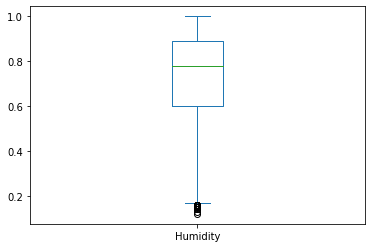

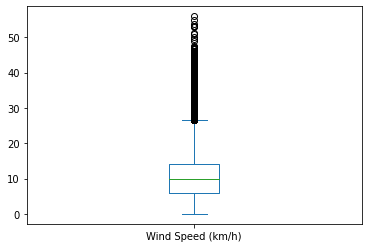

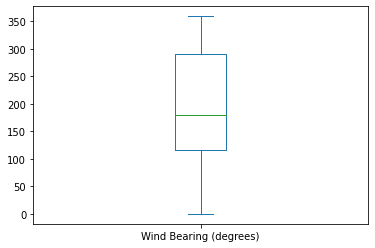

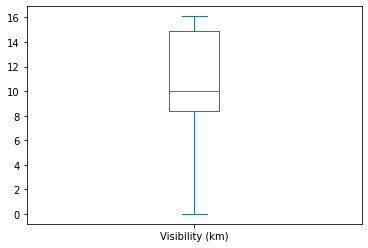

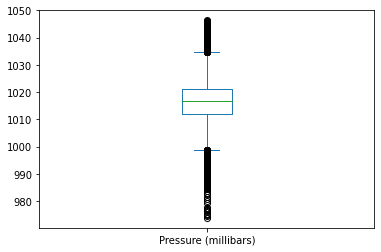

In [10]:
for col in df.columns[2:]:
    df[col].plot(kind="box")
    plt.show()

<AxesSubplot:>

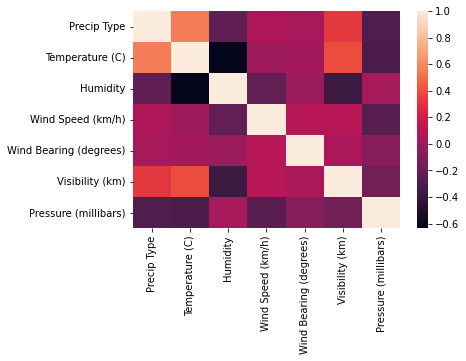

In [11]:
sns.heatmap(df.corr())

In [12]:
df.corr()

,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Precip Type,1.000000,0.552650,-0.232598,0.065800,0.040739,0.318842,-0.297639
Temperature (C),0.552650,1.000000,-0.636691,0.010070,0.030368,0.392261,-0.309894
Humidity,-0.232598,-0.636691,1.000000,-0.224803,0.000992,-0.372174,0.040614
Wind Speed (km/h),0.065800,0.010070,-0.224803,1.000000,0.101580,0.102858,-0.253649
Wind Bearing (degrees),0.040739,0.030368,0.000992,0.101580,1.000000,0.047491,-0.078340
Visibility (km),0.318842,0.392261,-0.372174,0.102858,0.047491,1.000000,-0.166116
Pressure (millibars),-0.297639,-0.309894,0.040614,-0.253649,-0.078340,-0.166116,1.000000


In [13]:
df.head(1)

,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,1,9.472222,0.89,14.1197,251.0,15.8263,1015.13


In [14]:
df["Precip Type"].value_counts()

1    84114
0    11028
Name: Precip Type, dtype: int64

In [15]:
df["Precip Type"] == "rain"

0        False
1        False
2        False
3        False
4        False
         ...  
96448    False
96449    False
96450    False
96451    False
96452    False
Name: Precip Type, Length: 95142, dtype: bool

In [16]:
(df["Precip Type"] == "rain").astype(int)

0        0
1        0
2        0
3        0
4        0
        ..
96448    0
96449    0
96450    0
96451    0
96452    0
Name: Precip Type, Length: 95142, dtype: int64

In [17]:
#df["rain/snow prediction"] = (df["Precip Type"] == "rain").astype(int)

In [18]:
df["Precip Type"]

0        1
1        1
2        1
3        1
4        1
        ..
96448    1
96449    1
96450    1
96451    1
96452    1
Name: Precip Type, Length: 95142, dtype: int64

In [19]:
target = "Precip Type"
y = df[target]
X = df.drop(columns = target)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from category_encoders import OneHotEncoder, OrdinalEncoder

In [22]:
from sklearn.pipeline import make_pipeline

In [23]:
model_lr = make_pipeline(
    LogisticRegression()
)
model_lr.fit(X_train, y_train)

Pipeline(steps=[('logisticregression', LogisticRegression())])

In [24]:
lr_train_accuracy = model_lr.score(X_train, y_train)
print(lr_train_accuracy)

0.9856003573633939


In [25]:
lr_val_accuracy = model_lr.score(X_val, y_val)
print(lr_val_accuracy)

0.9859687844868359


In [26]:
model_lr.predict(X_train)

array([0, 1, 1, ..., 1, 1, 1])

In [27]:
df.columns

Index(['Precip Type', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)'],
      dtype='object')

In [28]:
df.columns

Index(['Precip Type', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)'],
      dtype='object')

**Use the date time to predict temp i.e case of time series**

In [29]:
def wrangle1(filepath, resample_rule = '1H'):
    df1 = pd.read_csv(filepath).set_index("Formatted Date")
    df1.drop(columns = ['Summary', 'Precip Type',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary'], inplace = True)
    
    df1.index = pd.to_datetime(df1.index)
    
    #resample to 1h
    #df1 = df1["Temperature (C)"].resample(resample_rule).mean().fillna(method='ffill').to_frame()
    
    #Shift by 1 to get the feature /target for time series
    
    df1["Temperature.L1"] = df1["Temperature (C)"].shift(1)
    df1.dropna(inplace=True)
    
    return df1

In [30]:
df1 = wrangle1("/kaggle/input/weather-dataset/weatherHistory.csv")
df1.head()

,Temperature (C),Temperature.L1
Formatted Date,,
2006-04-01 01:00:00+02:00,9.355556,9.472222
2006-04-01 02:00:00+02:00,9.377778,9.355556
2006-04-01 03:00:00+02:00,8.288889,9.377778
2006-04-01 04:00:00+02:00,8.755556,8.288889
2006-04-01 05:00:00+02:00,9.222222,8.755556


<AxesSubplot:>

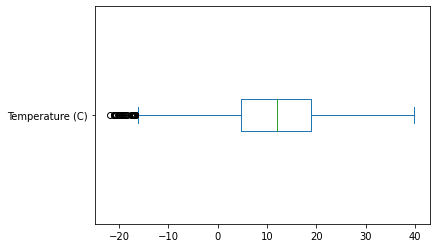

In [31]:
df["Temperature (C)"].plot(kind="box", vert=False)

<AxesSubplot:>

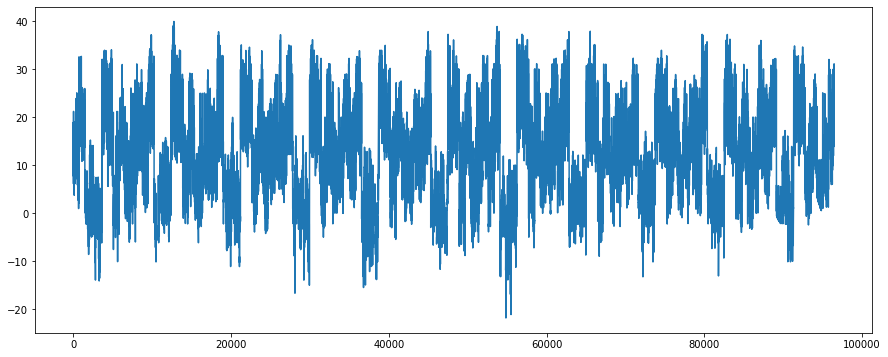

In [32]:
fig, ax = plt.subplots(figsize = (15, 6))
df["Temperature (C)"].plot(ax=ax)

<AxesSubplot:>

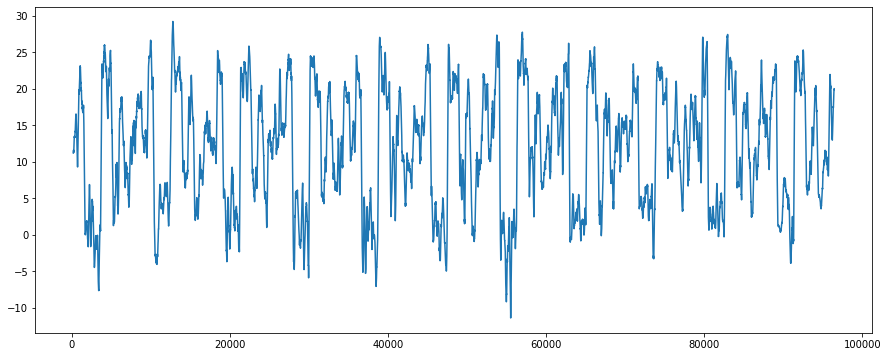

In [33]:
fig, ax = plt.subplots(figsize = (15, 6))
df["Temperature (C)"].rolling(168).mean().plot(ax=ax)

In [34]:
df1.corr()

,Temperature (C),Temperature.L1
Temperature (C),1.000000,0.986717
Temperature.L1,0.986717,1.000000


Build time series model

In [35]:
target1 = "Temperature (C)"
y1 = df1[target1]
X1 = df1.drop(columns = target1)

In [36]:
y1

Formatted Date
2006-04-01 01:00:00+02:00     9.355556
2006-04-01 02:00:00+02:00     9.377778
2006-04-01 03:00:00+02:00     8.288889
2006-04-01 04:00:00+02:00     8.755556
2006-04-01 05:00:00+02:00     9.222222
                               ...    
2016-09-09 19:00:00+02:00    26.016667
2016-09-09 20:00:00+02:00    24.583333
2016-09-09 21:00:00+02:00    22.038889
2016-09-09 22:00:00+02:00    21.522222
2016-09-09 23:00:00+02:00    20.438889
Name: Temperature (C), Length: 96452, dtype: float64

In [37]:
cutt_off1 = int(len(X1) * 0.8)

X_train1, y_train1 = X1.iloc[:cutt_off1], y1.iloc[:cutt_off1]
X_test1, y_test1 = X1.iloc[cutt_off1:], y1.iloc[cutt_off1:]

In [38]:
y_pred_baseline1 = [y_train1.mean()] * len(y_train1)
mae_baseline1 = mean_absolute_error(y_train1, y_pred_baseline1)
print(mae_baseline1, y_train1.mean())

8.019472980296596 11.83909732752153


In [39]:
model1 = LinearRegression()
model1.fit(X_train1, y_train1)

LinearRegression()

In [40]:
y_pred_training1 = model1.predict(X_train1)
mae_training1 = mean_absolute_error(y_train1, y_pred_training1)
print(mae_training1)

1.0573213650717281


In [41]:
y_pred_test1 = model1.predict(X_test1)
mae_test1 = mean_absolute_error(y_test1, y_pred_test1)
print(mae_test1)

0.9128830093148882


In [42]:
y_pred_test1 = pd.Series(model1.predict(X_test1))
y_pred_test1.head()

0   -0.770117
1    0.232675
2    0.512142
3    1.284785
4    2.353334
dtype: float64

In [43]:
df_pred_test1 = pd.DataFrame(
    {
        "y_test1" : y_test1,
        "y_pred" : model1.predict(X_test1)
    }
)
df_pred_test1.head()

,y_test1,y_pred
Formatted Date,,
2014-11-26 06:00:00+01:00,0.072222,-0.770117
2014-11-26 07:00:00+01:00,0.355556,0.232675
2014-11-26 08:00:00+01:00,1.138889,0.512142
2014-11-26 09:00:00+01:00,2.222222,1.284785
2014-11-26 10:00:00+01:00,2.916667,2.353334


In [44]:
import plotly.express as px

In [45]:
fig = px.line(df_pred_test1, labels = {"value": "Temp"})
fig.show()

<AxesSubplot:xlabel='Formatted Date'>

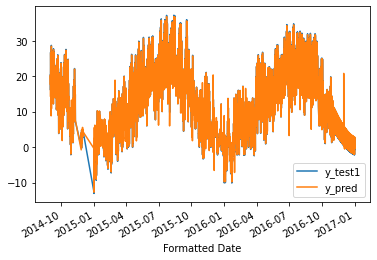

In [46]:
df_pred_test1.plot()

**AutoReg Model for time series**

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [48]:
def wrangle2(filepath, resample_rule = '1H'):
    df2 = pd.read_csv(filepath).set_index("Formatted Date")
    df2.drop(columns = ['Summary', 'Precip Type',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary'], inplace = True)
    
    df2.index = pd.to_datetime(df2.index)
    
    #resample to 1h
    #y = df2["Temperature (C)"].resample(resample_rule).mean().fillna(method='ffill')#.to_frame()
    
    #Shift by 1 to get the feature /target for time series
    
    #df2["Temperature.L1"] = df2["Temperature (C)"].shift(1)
    #df2.dropna(inplace=True)
    y = df2.squeeze()
    return y

In [49]:
df2 = wrangle2("/kaggle/input/weather-dataset/weatherHistory.csv")
df2.head()

Formatted Date
2006-04-01 00:00:00+02:00    9.472222
2006-04-01 01:00:00+02:00    9.355556
2006-04-01 02:00:00+02:00    9.377778
2006-04-01 03:00:00+02:00    8.288889
2006-04-01 04:00:00+02:00    8.755556
Name: Temperature (C), dtype: float64

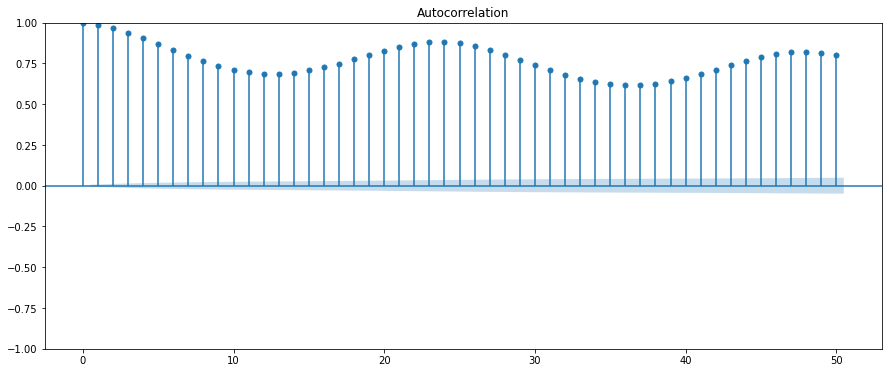

In [50]:
fig, ax = plt.subplots(figsize = (15, 6))
plot_acf(df2, ax=ax);

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



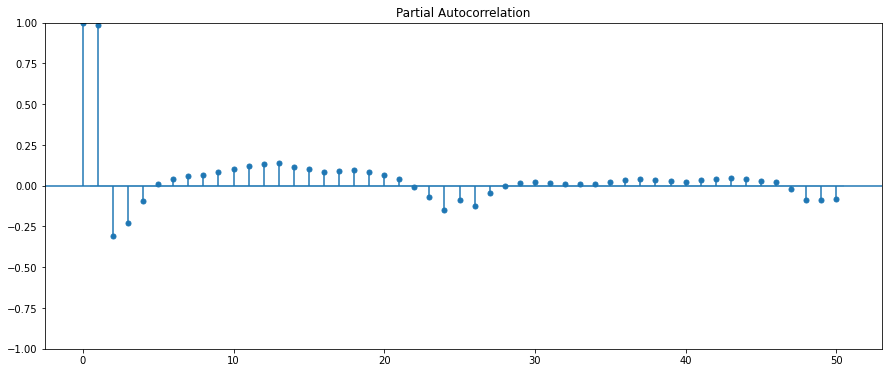

In [51]:
fig, ax = plt.subplots(figsize = (15, 6))
plot_pacf(df2, ax=ax);

In [52]:
cutt_off2 = int(len(X1) * 0.8)
# y_train2 = df2["Temperature (C)"].iloc[:cutt_off2]
# y_test2 = df2["Temperature (C)"].iloc[cutt_off2:]

y_train2 = y.iloc[:cutt_off2]
y_test2 = y.iloc[cutt_off2:]

In [53]:
y_pred_baseline2 = [y_train2.mean()] * len(y_train2)
mae_baseline2 = mean_absolute_error(y_train2, y_pred_baseline2)
print(mae_baseline2, y_train2.mean())

0.21331730096846518 0.8786044763546351


In [54]:
# model2 = AutoReg(y_train2, lags = 25).fit()

In [55]:
#model2.predict()

In [56]:
#model2.predict().isnull().sum()

In [57]:
# y_pred2 = model2.predict().dropna()
# mae_training2 = mean_absolute_error(y_train2.iloc[28:], y_pred2)
# print(mae_training2)